In [1]:
%matplotlib inline
from itertools import cycle
from os import listdir
from os.path import join
from glob import glob
from scipy.interpolate import interp1d, splrep, splev

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
from utils import load_file

In [3]:
path_directory = 'X:/SSI/20160621_mapping/03_test/' 
path_results = 'results/hvite/'

In [12]:
dirs = sorted(listdir(path_directory))

directories = [join(path_directory, directory, path_results) for directory in dirs]

### Accuracy

In [5]:
def reglob(path, exp, invert=False):
    """glob.glob() style searching which uses regex

    :param exp: Regex expression for filename
    :param invert: Invert match to non matching files
    """

    m = re.compile(exp)

    if invert is False:
        res = [f for f in listdir(path) if m.search(f)]
    else:
        res = [f for f in listdir(path) if not m.search(f)]

    res = map(lambda x: "%s/%s" % ( path, x, ), res)
    return res

In [6]:
def get_accuracy(files):
    re_acc_pattern = re.compile('word:.+Acc=(\d+\.\d+)', re.I)
    re_lm_weight = re.compile('lm-w(\d+)')
    
    for file in files:
        weight = re_lm_weight.search(file).group(1)
        
        for line in load_file(file):
            match = re_acc_pattern.match(line)
            if not match:
                continue
            yield int(weight), float(match.group(1))

In [7]:
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

def draw_accuracy(accuracy, name):
    # Unzip weight and accuracy.   
    accuracy = sorted(accuracy)
    x, y = zip(*accuracy)
    xmax = max(x)
    # Extrapolate
    xnew = np.linspace(1, xmax * 1.1, num=60, endpoint=True)
    tck = splrep(x, y, k=2, s=0)
    ynew = splev(xnew, tck)
    
    # Plot    
    color = next(colors)
    plt.plot(xnew, ynew, '-', c=color, label=name)
    plt.plot(x, y, 'o', xnew, [max(ynew)] * 60, '--', c=color)
    plt.xlabel('Insertion penalty')
    plt.ylabel('Accuracy')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    
    return max(accuracy, key=lambda x: x[1])

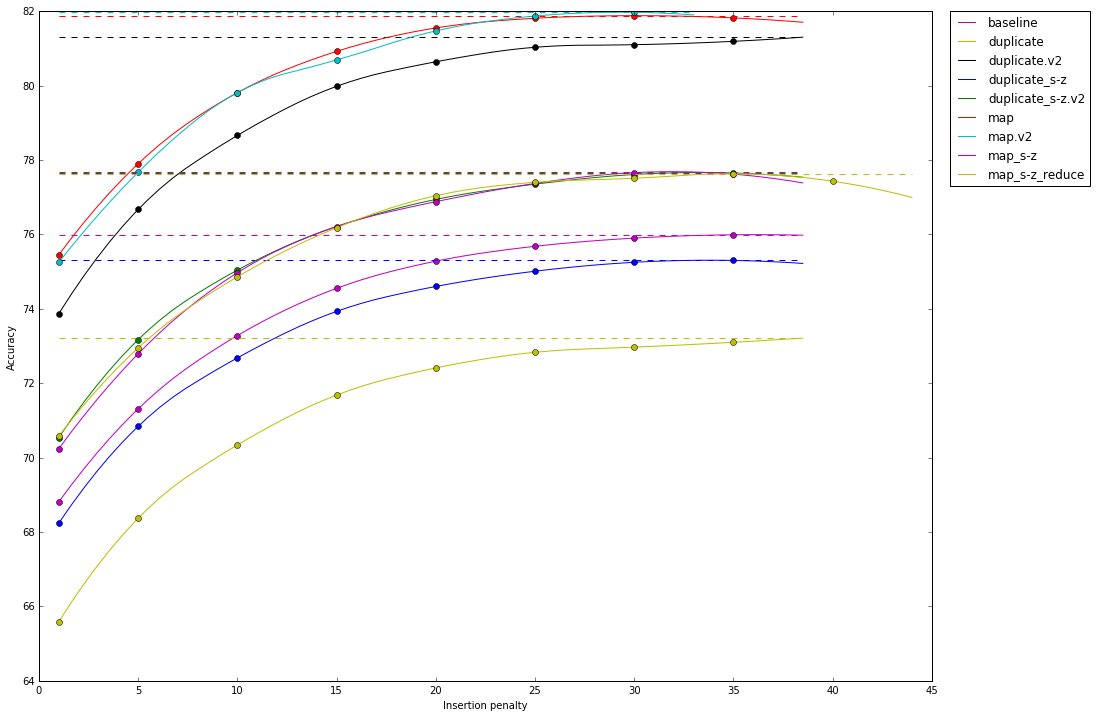

In [15]:
fig = plt.figure(figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')
columns = ['type', 'accuracy', 'weight']
df = pd.DataFrame(columns=columns)

for directory, path in zip(dirs, directories):
    paths = reglob(path, 'hvite_t01_lm-w[0-9]+.pyeval.txt')
    accuracy = get_accuracy(paths)
    weight, value = draw_accuracy(accuracy, directory)
    df = df.append(pd.DataFrame([[directory, value, weight]], columns=columns), ignore_index=True)
    
plt.show()

In [20]:
print(df.sort_values(by=['accuracy'], ascending=[0]))

               type  accuracy  weight
6            map.v2     81.97    30.0
5               map     81.88    30.0
2      duplicate.v2     81.19    35.0
7           map_s-z     77.66    30.0
4  duplicate_s-z.v2     77.65    35.0
8    map_s-z_reduce     77.63    35.0
0          baseline     75.99    35.0
3     duplicate_s-z     75.30    35.0
1         duplicate     73.10    35.0
